In [1]:
import sklearn
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images
import numpy as np

## Using Pretrained Models from Keras

In general, you won’t have to implement standard models like GoogLeNet or ResNet manually, since pretrained networks are readily available with a single line of code in the tf.keras.applications package.

For example, you can load the ResNet-50 model, pretrained on ImageNet, with the following line of code:

In [2]:
model = tf.keras.applications.ResNet50(weights="imagenet")

That’s all! This will create a ResNet-50 model and download weights pretrained on the ImageNet dataset. 

To use it, you first need to ensure that the images have the right size. A ResNet-50 model expects 224 × 224–pixel images (other models may expect other sizes, such as 299 × 299), so let’s use Keras’s Resizing layer to resize two sample images (after cropping them to the target aspect ratio)

In [3]:
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

預訓練模型假設圖像以特定方式進行預處理。 在某些情況下，他們可能期望輸入從 0 縮放到 1，或者從 –1 縮放到 1，等等。 每個模型都提供了一個 preprocess_input() 函數，可用於預處理圖像。 這些函數假設原始像素值範圍從 0 到 255，如下所示：

In [4]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

Now we can use the pretrained model to make predictions:

In [5]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 1s 1s/step


(2, 1000)

As usual, the output Y_proba is a matrix with one row per image and one column per class (in this case, there are 1,000 classes). If you want to display the top K predictions, including the class name and the estimated probability of each predicted class, use the decode_predictions() function. For each image, it returns an array containing the top K predictions, where each prediction is represented as an array containing the class identifier,⁠28 its name, and the corresponding confidence score:

In [6]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%


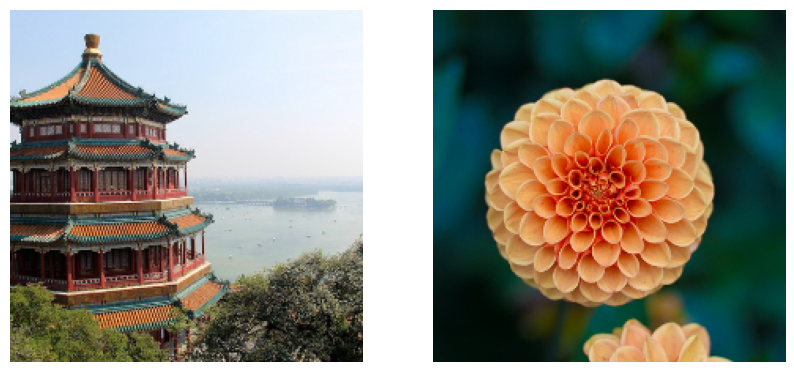

In [7]:
#displays the cropped and resized images

plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

正確的類別是宮殿(palace)和大麗花(dahlia)，因此模型對於第一張圖像是正確的，但對於第二張圖像是錯誤的。 然而，這是因為大麗花不是 1,000 個 ImageNet 類別之一。 考慮到這一點，花瓶是一個合理的猜測（也許花在花瓶裡？），而雛菊也不是一個壞選擇，因為大麗花和雛菊都來自同一個菊科。

正如所看到的，使用預訓練模型創建一個非常好的圖像分類器非常容易。 tf.keras.applications 中提供了許多其他視覺模型，從輕量級快速模型到大型精確模型。

但是，如果想對不屬於 ImageNet 的圖像類別使用圖像分類器怎麼辦？ 在這種情況下，仍然可以通過使用預訓練模型執行transfer learning來受益

## Pretrained Models for Transfer Learning

If you want to build an image classifier but you do not have enough data to train it from scratch, then it is often a good idea to reuse the lower layers of a pretrained model.

For example, let’s train a model to classify pictures of flowers, reusing a pretrained Xception model. 

First, we’ll load the flowers dataset using TensorFlow Datasets

In [9]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [10]:
dataset_size, class_names, n_classes

(3670, ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], 5)

Unfortunately, there is only a "train" dataset, no test set or validation set, so we need to split the training set. Let’s call tfds.load() again, but this time taking the first 10% of the dataset for testing, the next 15% for validation, and the remaining 75% for training:

In [11]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

All three datasets contain individual images. We need to batch them, but first we need to ensure they all have the same size, or batching will fail. We can use a 
Resizing layer for this. We must also call the tf.keras.applications.​xcep⁠tion.preprocess_input() function to preprocess the images appropriately for the Xception model. Lastly, we’ll also shuffle the training set and use prefetching:

In [12]:
tf.keras.backend.clear_session()  

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Let's take a look at the first 9 images from the validation set: they're all 224x224 now, each batch contains 32 images with values ranging from -1 to 1:

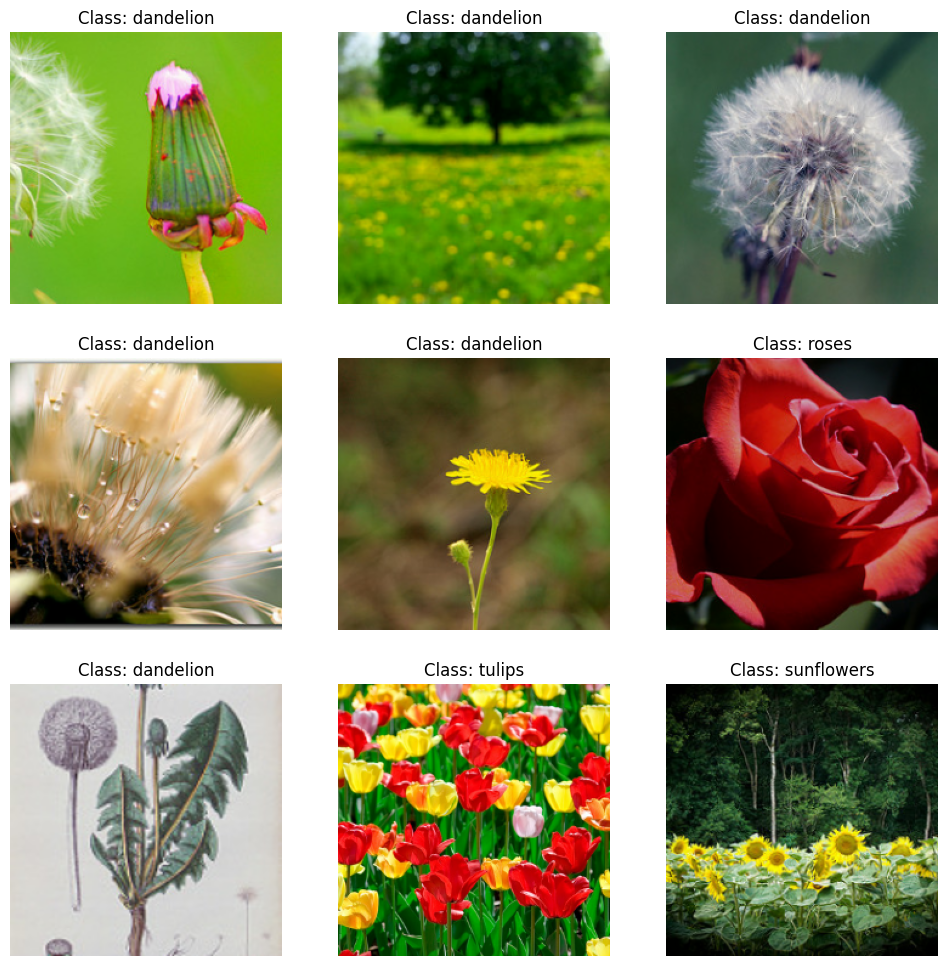

In [13]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

Since the dataset is not very large, a bit of data augmentation will certainly help. Let’s create a data augmentation model that we will embed in our final model. During training, it will randomly flip the images horizontally, rotate them a little bit, and tweak the contrast:

In [23]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

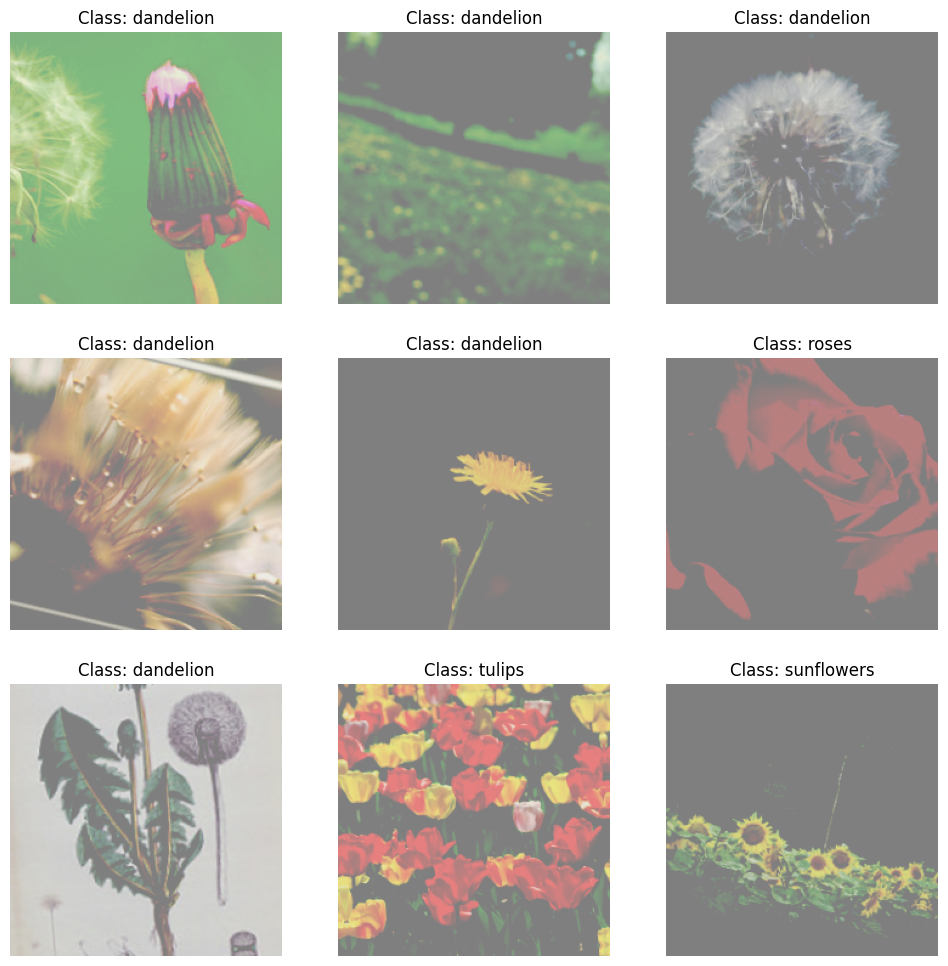

In [26]:
#displays the same first 9 images, after augmentation
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

Next let’s load an Xception model, pretrained on ImageNet. We exclude the top of the network by setting include_top=False. This excludes the global average pooling layer and the dense output layer. We then add our own global average pooling layer (feeding it the output of the base model), followed by a dense output layer with one unit per class, using the softmax activation function. Finally, we wrap all this in a Keras Model:

In [15]:
tf.random.set_seed(42)  
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

**It’s usually a good idea to freeze the weights of the pretrained layers, at least at the beginning of training:**

In [16]:
for layer in base_model.layers:
    layer.trainable = False

Finally, we can compile the model and start training:

(If you are running in Colab, make sure the runtime is using a GPU: select Runtime → “Change runtime type”, choose “GPU” in the “Hardware accelerator” drop-down menu, then click Save. It’s possible to train the model without a GPU, but it will be terribly slow (minutes per epoch, as opposed to seconds.)

In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 204s 2s/step - loss: 0.5342 - accuracy: 0.8201 - val_loss: 26.6791 - val_accuracy: 0.3902
Epoch 2/3
86/86 [==============================] - 195s 2s/step - loss: 0.2438 - accuracy: 0.9259 - val_loss: 0.4360 - val_accuracy: 0.8639
Epoch 3/3
86/86 [==============================] - 205s 2s/step - loss: 0.1177 - accuracy: 0.9648 - val_loss: 0.5327 - val_accuracy: 0.8403


After training the model for a few epochs, its validation accuracy should reach a bit over 80% and then stop improving. This means that the top layers are now pretty well trained, and we are ready to unfreeze some of the base model’s top layers, then continue training. For example, let’s unfreeze layers 56 and above (that’s the start of residual unit 7 out of 14, as you can see if you list the layer names):

In [32]:
#list the layer names
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [17]:
for layer in base_model.layers[56:]:
    layer.trainable = True


**Don’t forget to compile the model whenever you freeze or unfreeze layers. Also make sure to use a much lower learning rate to avoid damaging the pretrained weights:**

In [34]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 254s 3s/step - loss: 0.2704 - accuracy: 0.9092 - val_loss: 0.4995 - val_accuracy: 0.8639
Epoch 2/10
86/86 [==============================] - 232s 3s/step - loss: 0.0665 - accuracy: 0.9826 - val_loss: 0.3794 - val_accuracy: 0.9056
Epoch 3/10
86/86 [==============================] - 239s 3s/step - loss: 0.0160 - accuracy: 0.9953 - val_loss: 0.3096 - val_accuracy: 0.9220
Epoch 4/10
86/86 [==============================] - 503s 6s/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.3467 - val_accuracy: 0.9111
Epoch 5/10
86/86 [==============================] - 581s 7s/step - loss: 0.0107 - accuracy: 0.9971 - val_loss: 0.3509 - val_accuracy: 0.9038
Epoch 6/10
86/86 [==============================] - 581s 7s/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.3649 - val_accuracy: 0.9020
Epoch 7/10
86/86 [==============================] - 581s 7s/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.3474 - val_accuracy: 0.9020
Epoch 8/10
86

If you tune the hyperparameters, lower the learning rate, and train for quite a bit longer, you should be able to reach 95% to 97%. With that, you can start training amazing image classifiers on your own images and classes! But there’s more to computer vision than just classification. For example, what if you also want to know where the flower is in a picture? Let’s look at this now.

## Classification and Localization

Localizing an object in a picture can be expressed as a regression task to predict a bounding box around the object, a common approach is to predict the horizontal and vertical coordinates of the object’s center, as well as its height and width. This means we have four numbers to predict. It does not require much change to the model; we just need to add a second dense output layer with four units (typically on top of the global average pooling layer), and it can be trained using the MSE loss:

In [13]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

But now we have a problem: the flowers dataset does not have bounding boxes around the flowers. So, we need to add them ourselves. This is often one of the hardest and most costly parts of a machine learning project: getting the labels. It’s a good idea to spend time looking for the right tools. To annotate images with bounding boxes, you may want to use an open source image labeling tool like VGG Image Annotator, LabelImg, OpenLabeler, or ImgLab, or perhaps a commercial tool like LabelBox or Supervisely. You may also want to consider crowdsourcing platforms such as Amazon Mechanical Turk if you have a very large number of images to annotate. However, it is quite a lot of work to set up a crowdsourcing platform, prepare the form to be sent to the workers, supervise them, and ensure that the quality of the bounding boxes they produce is good, so make sure it is worth the effort. Adriana Kovashka et al. wrote a very practical paper⁠ about crowdsourcing in computer vision. I recommend you check it out, even if you do not plan to use crowdsourcing. If there are just a few hundred or a even a couple thousand images to label, and you don’t plan to do this frequently, it may be preferable to do it yourself: with the right tools, it will only take a few days, and you’ll also gain a better understanding of your dataset and task